## Entrenamos una red neuronal convolucional para superresolución

#### Cargamos las bibliotecas necesarias

In [1]:
#! pip install mlxtend
#! pip install plot_keras_history
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import shutil

from sklearn.metrics import confusion_matrix, classification_report

from mlxtend.plotting import plot_confusion_matrix

from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, Accuracy

# Importamos algunas dependencias fundamentales de la API de tensorflow
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization, Dropout, LeakyReLU


from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from plot_keras_history import plot_history

from sklearn.model_selection import train_test_split





2024-09-23 23:59:37.587648: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Definimos las rutas del dataset completo.

In [2]:
#Se toman las primeras 50.000 imágenes como entrenamiento, las 10.000 siguientes como validacion y las 10.000 restantes como test
# En cada carpeta hay 10000 imágenes, tomamos las primeras 50 carpetas para entrenamiento, las 10 siguientes para validación y las 10 últimas para test Las separamos manualmente.
ruta_actual = os.getcwd()

rutas_entrenamiento = os.path.join(ruta_actual,"caras","entrenamiento") 
rutas_validacion = os.path.join(ruta_actual,"caras","validacion")
rutas_test = os.path.join(ruta_actual,"caras","test")

#### Definimos el dataset para entrenamiento, validación y test usando la API tf.data.Dataset

In [3]:
alto = 64
ancho = 64

tamano_lote = 32

'''
def reduccion_imagen(imagen,escala = 8):
    
    ancho_imagen = int(imagen.shape[1]/escala)
    alto_imagen = int(imagen.shape[0]/escala)
    dimensiones_imagen_reducida=(alto_imagen,ancho_imagen)
    
    imagen_reducida = cv2.resize(imagen, dimensiones_imagen_reducida, interpolation=cv2.INTER_LINEAR)
    return imagen_reducida

def ampliar_imagen(imagen,dimension_original):
    #Ampliamos al tamaño original
    imagen_ampliada = cv2.resize(imagen,(dimension_original[1],dimension_original[0]),interpolation=cv2.INTER_CUBIC)
    
    return imagen_ampliada
'''

def reduccion_imagen(imagen,escala = 2):

    # Obtenemos las dimensiones originales
    dimensiones_originales = tf.shape(imagen)[:2]

    # Calculamos nuevas dimensiones
    nuevas_dimensiones = tf.cast(tf.round(dimensiones_originales/ escala), tf.int32)
    
    #redimensionamos la imagen
    imagen_reducida = tf.image.resize(imagen,nuevas_dimensiones,method='bilinear')
    
    return imagen_reducida

def ampliar_imagen(imagen,dimension_original):
    #Ampliamos al tamaño original
    imagen_ampliada = tf.image.resize(imagen, dimension_original, method='bicubic')
      
    
    return imagen_ampliada


#Definimos una fución para preprocesar las imágenes del dataset
def cargar_preprocesar_imagen(ruta):
    imagen = tf.io.read_file(ruta)
    imagen = tf.image.decode_jpeg(imagen, channels=3)

    # Convertimos la imagen a float32
    imagen = tf.image.convert_image_dtype(imagen, dtype=tf.float32)

    #Con la línea anterior la imagen ya se normaliza a valores entre 0 y 1. la siguiente línea sería erronea
    #imagen = imagen / 255.0
    
    dimensiones_originales = tf.shape(imagen)[:2]

    nuevas_dimensiones = tf.cast(tf.round(dimensiones_originales/ 16), tf.int32)
    imagen = tf.image.resize(imagen,nuevas_dimensiones,method='bilinear')
    
    reduccion = reduccion_imagen(imagen, escala=2)
    ampliacion = ampliar_imagen(reduccion,nuevas_dimensiones)

    
    # Convertimos la imagen disusa a float32
    ampliacion = tf.image.convert_image_dtype(ampliacion, dtype=tf.float32)

    
    #normalizamos las imágenes a valores entre 0 y 1
    #imagen_difusa = ampliacion / 255.0
    #imagen_difusa=ampliacion
    
    return ampliacion, imagen



'''
#Definimos una fución para preprocesar las imágenes del dataset
def cargar_preprocesar_imagen(ruta):
    imagen = tf.io.read_file(ruta)
    imagen = tf.image.decode_jpeg(imagen, channels=3)

    dimensiones_originales = tf.shape(imagen)[:2]
    
    reduccion = reduccion_imagen(imagen, escala=32)
    ampliacion = ampliar_imagen(reduccion,dimensiones_originales)

    # Convertimos la imagen a float32
    imagen = tf.image.convert_image_dtype(imagen, dtype=tf.float32)

    # Convertimos la imagen disusa a float32
    ampliacion = tf.image.convert_image_dtype(ampliacion, dtype=tf.float32)

    
    #normalizamos las imágenes a valores entre 0 y 1
    imagen = imagen / 255.0
    imagen_difusa = ampliacion / 255.0

    imagen_difusa=ampliacion
    
    return imagen_difusa, imagen
'''






#Construimos el dataset de entrenamiento
dataset_entrenamiento = tf.data.Dataset.list_files(rutas_entrenamiento + '/*/*.png')
numero_imagenes_entrenamiento = len(dataset_entrenamiento)

dataset_entrenamiento = dataset_entrenamiento.map(cargar_preprocesar_imagen,num_parallel_calls=tf.data.AUTOTUNE)
dataset_entrenamiento = dataset_entrenamiento.batch(tamano_lote)
dataset_entrenamiento = dataset_entrenamiento.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_entrenamiento = dataset_entrenamiento.repeat()  # Añadir repeat() para que se itere sobre el dataset una vez que se acaben los bastches


#Construimos el dataset de validación
dataset_validacion = tf.data.Dataset.list_files(rutas_validacion + '/*/*.png')
numero_imagenes_validacion = len(dataset_validacion)

dataset_validacion = dataset_validacion.map(cargar_preprocesar_imagen,num_parallel_calls=tf.data.AUTOTUNE)
dataset_validacion = dataset_validacion.batch(tamano_lote)
dataset_validacion = dataset_validacion.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_validacion = dataset_validacion.repeat()


#Construimos el dataset de test
dataset_test = tf.data.Dataset.list_files(rutas_test + '/*/*.png')
numero_imagenes_test = len(dataset_test)

dataset_test = dataset_test.map(cargar_preprocesar_imagen,num_parallel_calls=tf.data.AUTOTUNE)
dataset_test = dataset_test.batch(tamano_lote)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_test = dataset_test.repeat()


2024-09-23 23:59:40.164192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-23 23:59:40.239787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-23 23:59:40.239945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-23 23:59:40.241665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

#### Definimos la arquitectura del modelo para superesolución

In [4]:
def modelo_superresolucion(tamano_entrada = (None,None,3)):
    
    entrada = Input(shape=tamano_entrada)
    conv1 = Conv2D(filters = 128, kernel_size=(9,9),padding="same",activation="relu")(entrada)
    conv2 = Conv2D(filters = 64,kernel_size=(3,3),padding="same",activation="relu")(conv1)
    salida = Conv2D(filters = 3,kernel_size=(5,5),padding="same",activation="linear")(conv2)

    #Creamos el modelo usando la API funcional
    modelo  = Model(inputs=entrada,outputs=salida)

    return modelo
    

#### Instanciamos el modelo para superresolución que definimos previamente.

In [5]:
SRCNN = modelo_superresolucion()
SRCNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 128)   31232     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________


#### Definimos el optimizador, función de pérdida, early stopping y disminución de learning rate si no mejora el entrenamiento. También realizamos la compilación del modelo.

##### Definimos la tasa de aprendizaje y el optimizador deseado (Adam)

In [6]:
tasa_aprendizaje = 3e-4  #Tomamos la que se trata en teoría la mejor tasa de aprendizaje
  
optimizador =  Adam(learning_rate = tasa_aprendizaje)

##### Definimos parada temprana (EarlyStopping)

In [7]:
# Early stopping
parada_temprana = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

##### Definimos la caida del learning rate si el val_loss no mejora tras 5 épocas

In [8]:
# Reduce Learning rate on Plateau
reducir_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-8)

#### Compilamos el modelo

In [9]:
SRCNN.compile(optimizer=optimizador,loss = 'mean_squared_error', metrics=['mean_squared_error'] )

#### Calculamos los pasos de entrenamiento, de validación y del test del modelo

In [10]:
if numero_imagenes_entrenamiento % tamano_lote == 0:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote
else:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote +1

if numero_imagenes_validacion % tamano_lote == 0:
    pasos_validacion = numero_imagenes_validacion // tamano_lote
else:
    pasos_validacion = numero_imagenes_validacion // tamano_lote +1

if numero_imagenes_test % tamano_lote == 0:
    pasos_test = numero_imagenes_test // tamano_lote
else:
    pasos_test = numero_imagenes_test // tamano_lote +1


print(f"Número de pasos de entrenamiento para un batch size de {tamano_lote}: {pasos_entrenamiento}")
print(f"Número de pasos de validación para un batch size de {tamano_lote}: {pasos_validacion}")
print(f"Número de pasos de test para un batch size de para un batch size de {tamano_lote}: {pasos_test}")

Número de pasos de entrenamiento para un batch size de 32: 1563
Número de pasos de validación para un batch size de 32: 313
Número de pasos de test para un batch size de para un batch size de 32: 313


In [11]:
#TOmamos un lote del dataset y miramos las imágenes
lote = (dataset_entrenamiento.as_numpy_iterator()).next()

imagen_reconstruida = lote[0]
imagen_original = lote[1]


In [12]:
#imagen_reconstruida[1]
#imagen_original[0]

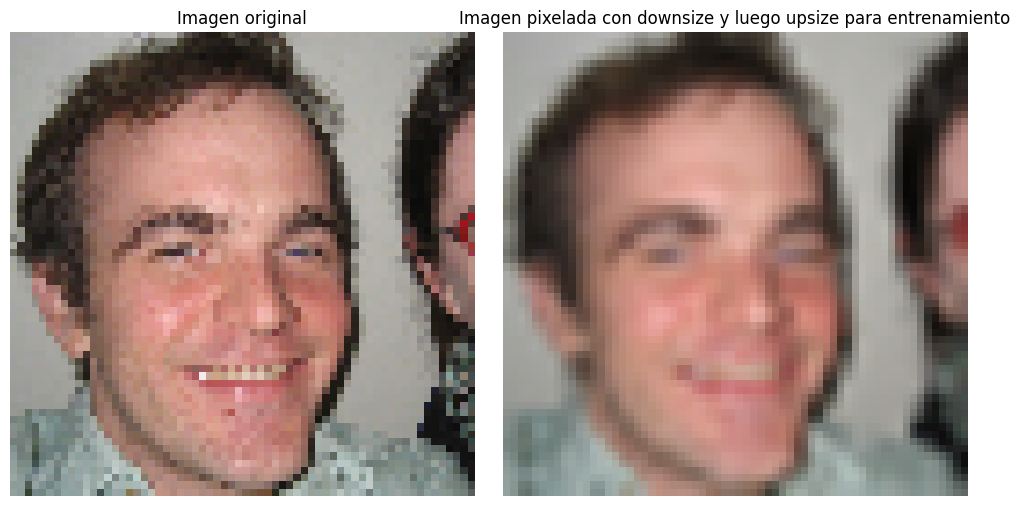

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 fila, 2 columnas

# Primera imagen
ax[0].imshow(np.clip(imagen_original[0],0,1))
ax[0].axis('off')  # Opcional: oculta los ejes
ax[0].set_title('Imagen original')  

# Segunda imagen
ax[1].imshow(np.clip(imagen_reconstruida[0],0,1))
ax[1].axis('off')  
ax[1].set_title('Imagen pixelada con downsize y luego upsize para entrenamiento')  

# Ajustamos el diseño para que las imágenes no se solapen
plt.tight_layout()

# Mostramos las imágenes
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009190673..1.0632076].


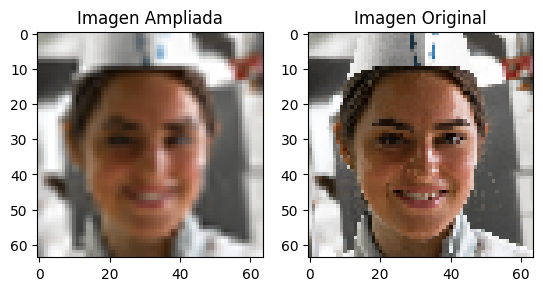

In [14]:
# Extraer una muestra del dataset
for ampliacion, original in dataset_entrenamiento.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(ampliacion[0].numpy())  # Imagen ampliada
    plt.title("Imagen Ampliada")

    plt.subplot(1, 2, 2)
    plt.imshow(original[0].numpy())  # Imagen original
    plt.title("Imagen Original")
    plt.show()


In [15]:
# Extraer una muestra del dataset
for ampliacion, original in dataset_entrenamiento.take(1):
    #print(ampliacion[0])
    print(original[0])

tf.Tensor(
[[[0.3901961  0.         0.        ]
  [0.44803923 0.         0.        ]
  [0.6156863  0.06470589 0.00686275]
  ...
  [0.14117648 0.08725491 0.03529412]
  [0.07843138 0.04117648 0.01666667]
  [0.08431373 0.05294118 0.01176471]]

 [[0.38627455 0.00098039 0.00098039]
  [0.38725495 0.         0.        ]
  [0.37156862 0.00196078 0.        ]
  ...
  [0.12843138 0.06666667 0.02647059]
  [0.07156863 0.03627452 0.02254902]
  [0.13333334 0.06862745 0.02156863]]

 [[0.4294118  0.         0.        ]
  [0.4911765  0.         0.00196078]
  [0.4666667  0.01568628 0.00686275]
  ...
  [0.17843139 0.09019609 0.0627451 ]
  [0.09607844 0.04607844 0.01372549]
  [0.16666669 0.07843138 0.0882353 ]]

 ...

 [[0.23039217 0.16568628 0.10294119]
  [0.23235296 0.15686275 0.09117648]
  [0.24803923 0.16862746 0.11078432]
  ...
  [0.01568628 0.05882353 0.29803923]
  [0.02843137 0.07745098 0.38235295]
  [0.02647059 0.0627451  0.35000002]]

 [[0.21568629 0.14803922 0.11764707]
  [0.2029412  0.15588236 0

#### Entrenamos por 25épocas la red. El entrenamiento puede que pare antes a causa del early stopping

In [16]:
# Entrenamiento del modelo
numero_epocas = 25

historia = SRCNN.fit(
    dataset_entrenamiento,
    epochs=numero_epocas,
    validation_data=dataset_validacion,
    steps_per_epoch=pasos_entrenamiento,
    validation_steps=pasos_validacion,
    callbacks=[parada_temprana, reducir_lr]
)

Epoch 1/25


2024-09-23 23:59:43.189515: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2024-09-23 23:59:44.413399: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-09-23 23:59:44.413419: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-09-23 23:59:44.413503: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1563/1563 [==============================] - 90s 55ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - lr: 3.0000e-04
Epoch 2/25
1563/1563 [==============================] - 87s 56ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - lr: 3.0000e-04
Epoch 3/25
1563/1563 [==============================] - 97s 62ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - lr: 3.0000e-04
Epoch 4/25
1563/1563 [==============================] - 99s 63ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - lr: 3.0000e-04
Epoch 5/25
1563/1563 [==============================] - 100s 64ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - lr: 3.0000e-05
Epoch 6/25
1563/1563 [==============================] - 100s 64ms/step - loss: 0.0033 - mean_sq

### Analizamos los resultados (error cuadrático medio) sobre el conjunto de entrenamiento y validación

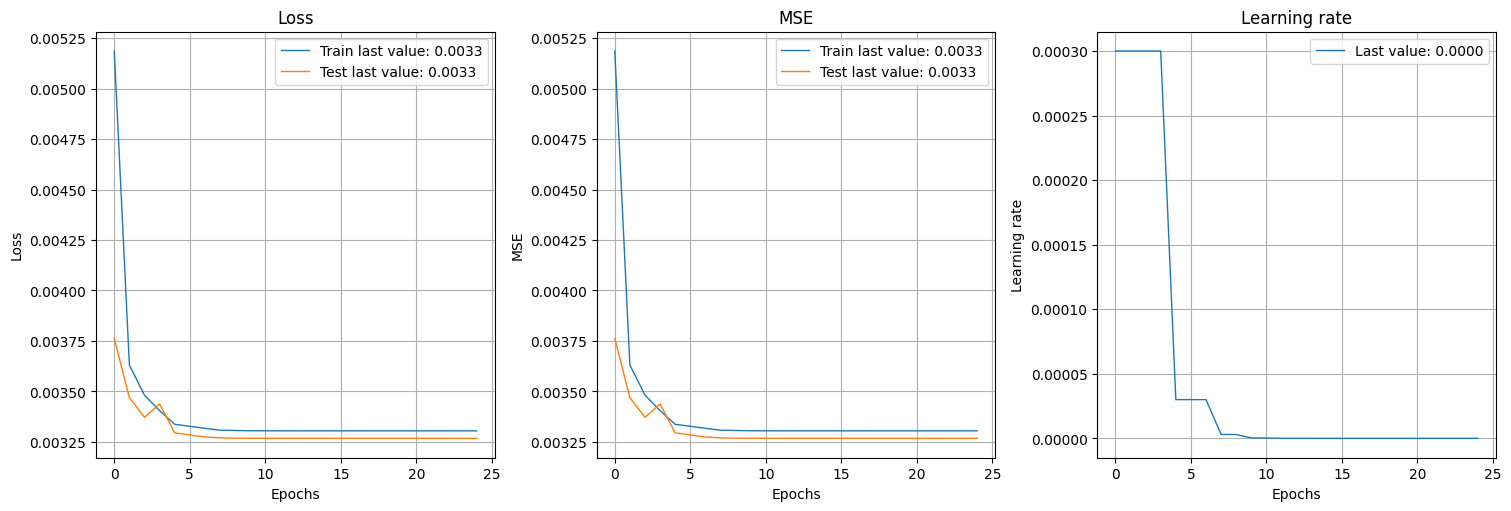

In [17]:
#Mostramos gráficas de interes del entrenamiento en función de las épocas

#from plot_keras_history import plot_history
plot_history(historia)
plt.show()

#### Guardamos los pesos de la red entrenada

In [18]:
SRCNN.save("srcnn_32_64.h5")


#### Podemos cargar los pesos del modelo

In [19]:
modelo_cargado = load_model("srcnn_32_64.h5")

In [20]:
lote = dataset_validacion.as_numpy_iterator().next()

lote_difusas = lote[0]
lote_original = lote[1]

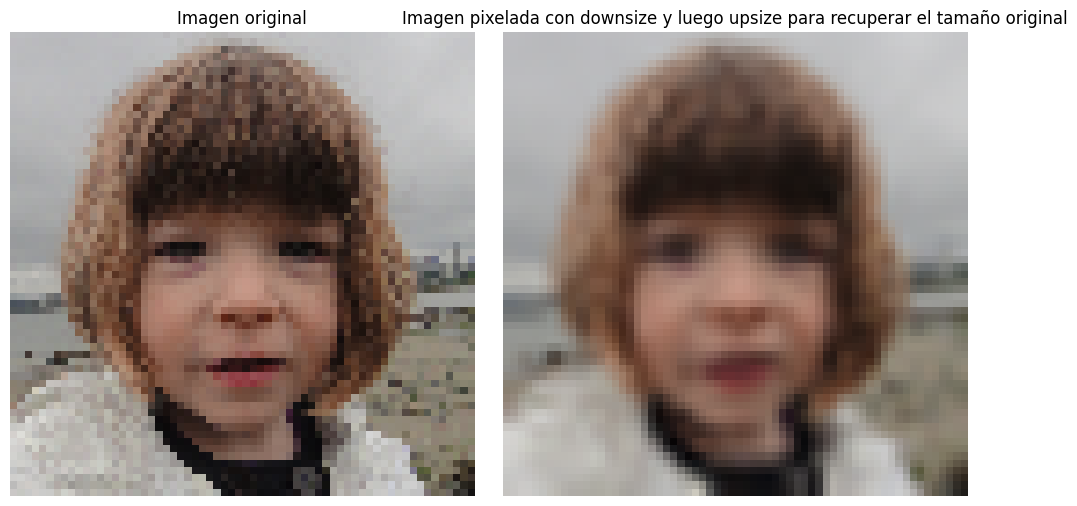

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 fila, 2 columnas

# Primera imagen
ax[0].imshow(np.clip(lote_original[0],0,255))
ax[0].axis('off')  # Opcional: oculta los ejes
ax[0].set_title('Imagen original')  

# Segunda imagen
ax[1].imshow(np.clip(lote_difusas[0],0,255))
ax[1].axis('off')  
ax[1].set_title('Imagen pixelada con downsize y luego upsize para recuperar el tamaño original')  

# Ajustamos el diseño para que las imágenes no se solapen
plt.tight_layout()

# Mostramos las imágenes
plt.show()



In [22]:
lote_reconstruidas = modelo_cargado.predict(lote_difusas) 

1/1 [==============================] - 0s 43ms/step


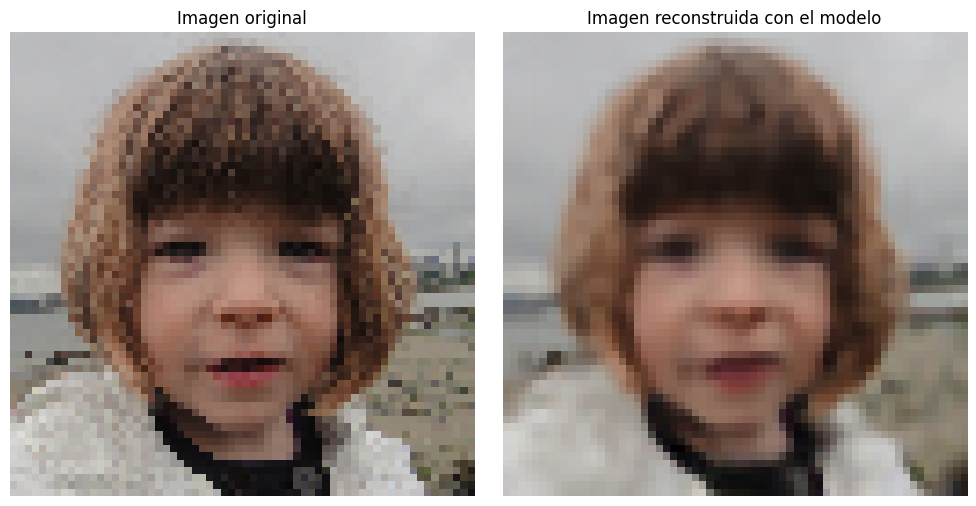

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 fila, 2 columnas

# Primera imagen
ax[0].imshow(np.clip(lote_original[0],0,255))
ax[0].axis('off')  # Opcional: oculta los ejes
ax[0].set_title('Imagen original')  

# Segunda imagen
ax[1].imshow(np.clip(lote_reconstruidas[0],0,255))
ax[1].axis('off')  
ax[1].set_title('Imagen reconstruida con el modelo')  

# Ajustamos el diseño para que las imágenes no se solapen
plt.tight_layout()

# Mostramos las imágenes
plt.show()